# Let's Play Moneyball
## Welcome to Week 2!

This week we'll be exploring the FIFA 2019 dataset, and seeing how we can use one of the most popular algorithms in data science and machine learning - Linear Regression - to make us millions of dollars. Even if sports is not your thing, this is a good lesson in excercising your curiosity. 

Your task will be to find the variables to predict strikers so our team can hire the best player, without spending too much money. We need to know who is undervalued, who is overvalued, and what variables create a great player. Let's get started!

In [44]:
import numpy as np   
import statsmodels.api as sm
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from itertools import combinations
from math import factorial
from matplotlib.pyplot import figure
plt.style.use('ggplot')

In [45]:
fifa_df = pd.read_csv("fifadata.csv")

In [46]:
print(fifa_df.head(10))

   Unnamed: 0      ID               Name  Age  \
0           0  158023           L. Messi   31   
1           1   20801  Cristiano Ronaldo   33   
2           2  190871          Neymar Jr   26   
3           3  193080             De Gea   27   
4           4  192985       K. De Bruyne   27   
5           5  183277          E. Hazard   27   
6           6  177003          L. Modrić   32   
7           7  176580          L. Suárez   31   
8           8  155862       Sergio Ramos   32   
9           9  200389           J. Oblak   25   

                                            Photo Nationality  \
0  https://cdn.sofifa.org/players/4/19/158023.png   Argentina   
1   https://cdn.sofifa.org/players/4/19/20801.png    Portugal   
2  https://cdn.sofifa.org/players/4/19/190871.png      Brazil   
3  https://cdn.sofifa.org/players/4/19/193080.png       Spain   
4  https://cdn.sofifa.org/players/4/19/192985.png     Belgium   
5  https://cdn.sofifa.org/players/4/19/183277.png     Belgium   
6  ht

In [47]:
print(fifa_df.columns)

Index(['Unnamed: 0', 'ID', 'Name', 'Age', 'Photo', 'Nationality', 'Flag',
       'Overall', 'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Preferred Foot', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Work Rate', 'Body Type', 'Real Face', 'Position',
       'Jersey Number', 'Joined', 'Loaned From', 'Contract Valid Until',
       'Height', 'Weight', 'LS', 'ST', 'RS', 'LW', 'LF', 'CF', 'RF', 'RW',
       'LAM', 'CAM', 'RAM', 'LM', 'LCM', 'CM', 'RCM', 'RM', 'LWB', 'LDM',
       'CDM', 'RDM', 'RWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'Crossing',
       'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
       'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingT

In [48]:
features = ['Acceleration','SprintSpeed','Agility', 'Stamina','Strength', 'Height', 'Finishing']
target = 'Value'

In [49]:
'''
Helper Functions to clean the data:
'''
def height_to_inches(h):
  if type(h) is str:
    hsplit = h.split("'")   # splits a string like 5'7 and returns the total inches
    feet = int(hsplit[0])
    inches = int(hsplit[1])
    return feet*12 + inches
  else:
    return h

def clean_weight(w):
  if type(w) is str:
    wnew = int(w.replace("lbs",""))
    return wnew
  else:
    return w

def clean_price(c):
  if type(c) is str:
    ismillion = False
    if "M" in c:
      ismillion = True
    cnew = float(c.replace("€", "").replace("M", "").replace("K", ""))
    if ismillion:
      cnew *= 1000000
    return cnew
  else:
    return c

# Actually clean up the dataset:

all_cols = [i for i in features]
all_cols.append(target)
cols_to_keep = [not i for i in fifa_df[all_cols].isna().any(axis=1)]
fifa_df = fifa_df[cols_to_keep]

print(fifa_df['Height'])
fifa_df['Height'] = fifa_df['Height'].apply(height_to_inches)
fifa_df['Height'].astype('int')
print(fifa_df['Height'])

print(fifa_df['Weight'])
fifa_df['Weight'] = fifa_df['Weight'].apply(clean_weight)
fifa_df['Weight'].astype('int')
print(fifa_df['Weight'])

# Ive commented these out as per the description from the code where we set
# the features above
'''
print(fifa_df['Value'])
fifa_df['Value'] = fifa_df['Value'].apply(clean_price)
fifa_df['Value'].astype('int')
print(fifa_df['Value'])

print(fifa_df['Release Clause'])
fifa_df['Release Clause'] = fifa_df['Release Clause'].apply(clean_price)
fifa_df['Release Clause'].astype('int')
print(fifa_df['Release Clause'])
'''

# Applying cleanup to the target as well
print(fifa_df['Value'])
fifa_df['Value'] = fifa_df['Value'].apply(clean_price)
fifa_df['Value'].astype('int')
print(fifa_df['Value'])

0         5'7
1         6'2
2         5'9
3         6'4
4        5'11
         ... 
18202     5'9
18203     6'3
18204     5'8
18205    5'10
18206    5'10
Name: Height, Length: 18159, dtype: object
0        67
1        74
2        69
3        76
4        71
         ..
18202    69
18203    75
18204    68
18205    70
18206    70
Name: Height, Length: 18159, dtype: int64
0        159lbs
1        183lbs
2        150lbs
3        168lbs
4        154lbs
          ...  
18202    134lbs
18203    170lbs
18204    148lbs
18205    154lbs
18206    176lbs
Name: Weight, Length: 18159, dtype: object
0        159
1        183
2        150
3        168
4        154
        ... 
18202    134
18203    170
18204    148
18205    154
18206    176
Name: Weight, Length: 18159, dtype: int64
0        €110.5M
1           €77M
2        €118.5M
3           €72M
4          €102M
          ...   
18202       €60K
18203       €60K
18204       €60K
18205       €60K
18206       €60K
Name: Value, Length: 18159, dtype: obj

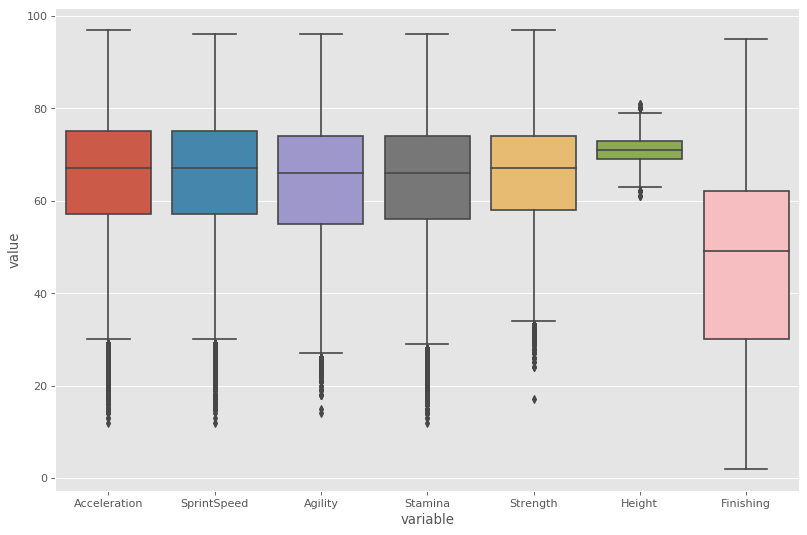

In [50]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
X = fifa_df[features]
sns.boxplot(x="variable", y="value", data=pd.melt(X))

In [51]:
fifa_df = fifa_df[fifa_df['Position'].str.contains('ST', na = False)]

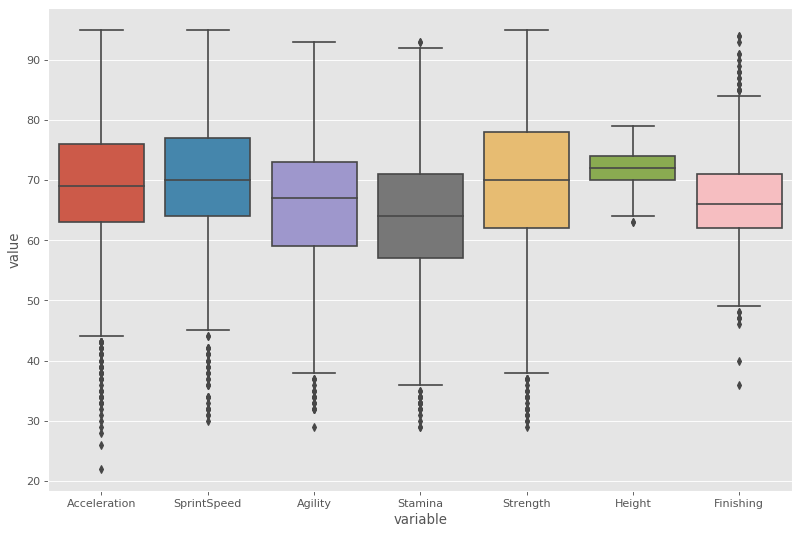

In [52]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
X = fifa_df[features]
sns.boxplot(x="variable", y="value", data=pd.melt(X))

In [159]:
fifa_df = fifa_df[fifa_df['SprintSpeed'] > 80]
fifa_df = fifa_df[fifa_df['Acceleration'] > 80]
fifa_df = fifa_df[fifa_df['Strength'] > 70]
fifa_df = fifa_df[fifa_df['Value'] < 50000000]
fifa_df = fifa_df[fifa_df['Finishing'] > 70]
X = fifa_df[features]
Y = fifa_df[target]

In [195]:
x = fifa_df['Finishing']
y = fifa_df['Overall']

In [161]:
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Overall   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     42.93
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           7.29e-07
Time:                        01:01:41   Log-Likelihood:                -61.006
No. Observations:                  27   AIC:                             126.0
Df Residuals:                      25   BIC:                             128.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.4074      8.678      2.352      0.0

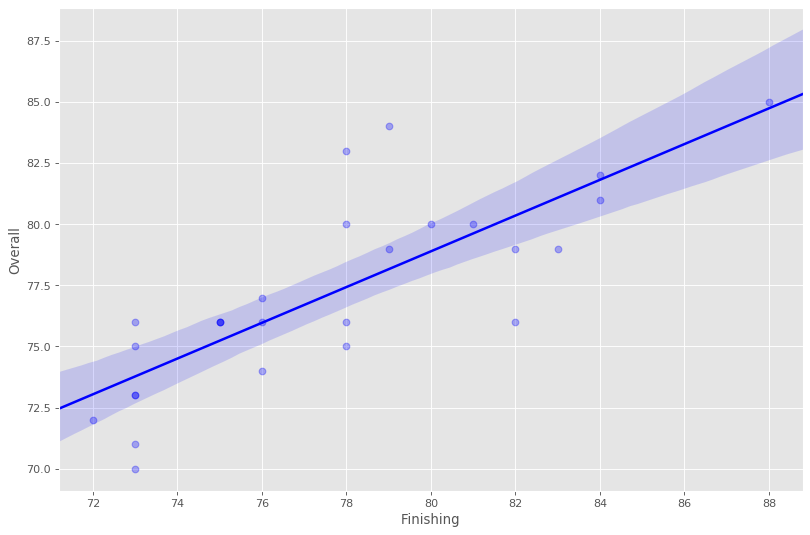

In [197]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sns.regplot(x, y, color='blue', scatter_kws={'alpha':0.3})

Residuals: 
87      0.260690
124     5.840089
193     5.571133
268     0.184867
381    -0.815133
430     0.378000
479     2.571133
518     1.109045
560     0.840089
561    -1.353044
653    -2.084088
1022    1.033222
1216    2.226355
1226   -1.428867
1237    0.764266
1347    0.764266
1386    0.033222
1404    0.764266
1507   -4.353044
2023    1.226355
2029   -2.428867
2253   -1.966778
2936   -0.773645
3210   -0.773645
3665   -1.042601
4519   -2.773645
5523   -3.773645
dtype: float64




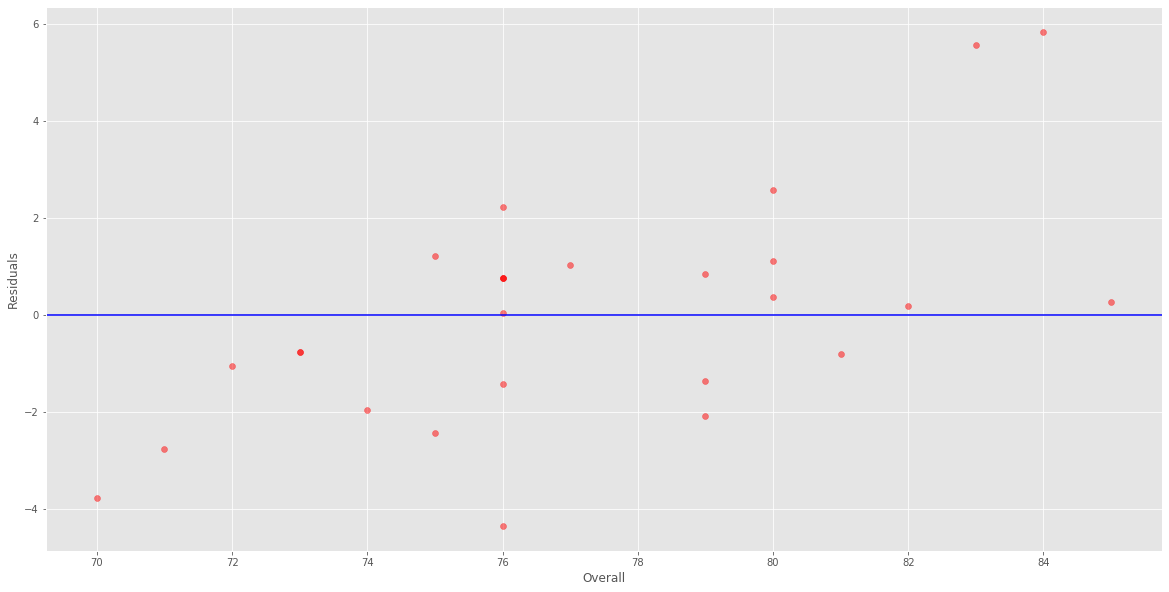

In [162]:
residuals = results.resid
print('Residuals: \n' + str(residuals) + '\n\n')

fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(fifa_df['Overall'], residuals, color='red', alpha=0.5)
plt.xlabel('Overall')
plt.ylabel('Residuals')
plt.axhline(y=0, color='b', linestyle='-')

In [ ]:
#Code Block, what other variables could predict overall?

In [163]:
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Value   R-squared (uncentered):                   0.832
Model:                            OLS   Adj. R-squared (uncentered):              0.774
Method:                 Least Squares   F-statistic:                              14.18
Date:                Mon, 24 Feb 2020   Prob (F-statistic):                    1.65e-06
Time:                        01:01:48   Log-Likelihood:                         -464.95
No. Observations:                  27   AIC:                                      943.9
Df Residuals:                      20   BIC:                                      953.0
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

Residuals: 
87      8.787345e+06
124     2.411410e+07
193     1.652026e+07
268     3.132396e+06
381    -6.809611e+05
430    -1.276193e+06
479     2.388526e+06
518    -1.387360e+06
560    -5.158239e+05
561    -5.770491e+06
653    -6.984291e+06
1022   -1.676520e+06
1216    4.166309e+06
1226   -1.120645e+07
1237   -3.144348e+04
1347    1.245129e+05
1386   -1.357433e+06
1404   -2.696954e+06
1507   -9.948175e+06
2023   -1.316991e+06
2029   -5.647523e+06
2253   -4.331384e+06
2936    6.755291e+06
3210   -4.923120e+06
3665   -3.221797e+05
4519   -2.474266e+06
5523   -4.159347e+06
dtype: float64




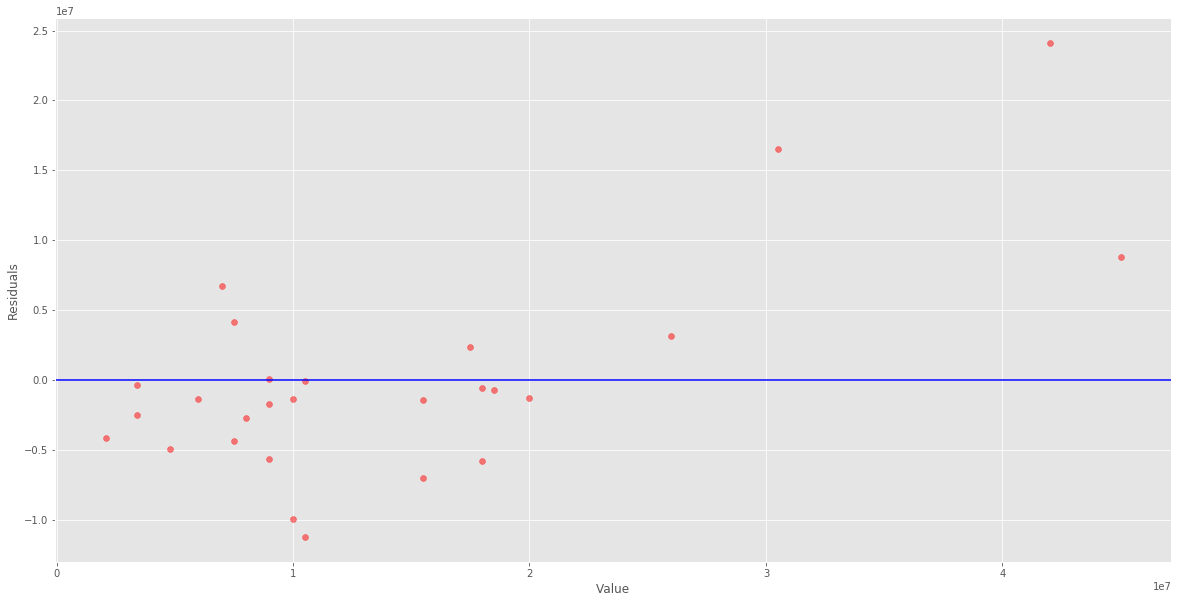

In [164]:
residuals = results.resid
print('Residuals: \n' + str(residuals) + '\n\n')

fig, ax = plt.subplots(figsize=(20,10))
plt.scatter(fifa_df['Value'], residuals, color='red', alpha=0.5)
plt.xlabel('Value')
plt.ylabel('Residuals')
plt.axhline(y=0, color='b', linestyle='-')

In [165]:
residuals = pd.DataFrame(data = residuals)
residuals = residuals[residuals < -500000]

In [166]:
m = residuals.dropna()
m

0
381  -6.809611e+05
430  -1.276193e+06
518  -1.387360e+06
560  -5.158239e+05
561  -5.770491e+06
653  -6.984291e+06
1022 -1.676520e+06
1226 -1.120645e+07
1386 -1.357433e+06
1404 -2.696954e+06
1507 -9.948175e+06
2023 -1.316991e+06
2029 -5.647523e+06
2253 -4.331384e+06
3210 -4.923120e+06
4519 -2.474266e+06
5523 -4.159347e+06

In [167]:
#fifa_df = fifa_df[fifa_df.Position.dropna()]
m = m.drop([0], axis = 1)

NEED HELP HERE, trying to go to return all players that are 'undervalued' below, but can't seem to get the values from m to match the values in Unnamed 0: , basically im running player = fifa_df[fifa_df['Unnamed: 0'].isin(m)] and it isn't working

In [168]:
m

Empty DataFrame
Columns: []
Index: [381, 430, 518, 560, 561, 653, 1022, 1226, 1386, 1404, 1507, 2023, 2029, 2253, 3210, 4519, 5523]

In [190]:
player = fifa_df[fifa_df['Unnamed: 0']==381]

In [192]:
player['Value']

381    18500000.0
Name: Value, dtype: float64